# Ajuste-fino da Arquitetura do Modelo e Hiperparâmetros RP

Com o estudo anterior (17), consolidamos a melhor `Taxa de Amostragem (= 5)` e o melhor `Tamanho de Janela` para cada aparelho da `residência 3` na base REDD.

Apesar de resultados satisfatórios, o processo de otimização considerou um pipeline canônico, escolhido aleatoriamente, composto de:
* Um conversor de séries em imagens baseado em Gráfico de Recorrência;
* Um modelo classificador baseado em CNN.

Neste sentido, a adoção de uma estratégia sistemática para escolha da arquitetura do modelo classificador e explotar diferentes combinações de hiperparâmetros do Gráfico de recorrência tendem a culminar em resultados de ponta para a identificação de cargas.

Portanto, neste estudo temos os seguintes objetivos:
1. Construir um modelo baseado em Deep Learning utilizando um arcabouço sistemático;
2. Varrer um conjunto discreto de valores combinatórios dos hiperparâmetros do RP.

# Configurações

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "18") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()

# Parametros dos dados
PARAMETROS_DATASET = {
    "base":redd,
    "id_residencia":3,
    "inicio_intervalo":'2011-04-16 05:11:30',
    "fim_intervalo":'2011-04-23 08:43:26',
    "debug": False    
}
print("PARÂMETROS DO ESTUDO:")
pprint(PARAMETROS_DATASET)

NILMTK -> Detalhes sobre o dataset REDD:



PARÂMETROS DO ESTUDO:
{'base': <nilmtk.dataset.DataSet object at 0x000001DA8D9E3B70>,
 'debug': False,
 'fim_intervalo': '2011-04-23 08:43:26',
 'id_residencia': 3,
 'inicio_intervalo': '2011-04-16 05:11:30'}


## Melhores Janelas para cada aparelho (estudo 17)

In [4]:
df_melhores_janelas = pd.read_csv(os.path.join(caminho_dados, "17", "taxa_5-melhoresjanelas.csv"))
df_melhores_janelas

,taxa_amostragem,carga,janela,loss,acuracia,f1_macro
0,5,sockets - 3,1080,0.103,93.10,73.15
1,5,sockets - 4,30,0.000,100.00,100.00
2,5,light - 5,1080,0.018,100.00,100.00
3,5,ce_appliance - 6,360,0.000,100.00,100.00
4,5,fridge - 7,360,0.000,100.00,100.00
5,5,waste_disposal_unit - 8,30,0.099,99.81,49.95
6,5,dish_washer - 9,60,0.092,97.67,74.40
7,5,electric_furnace - 10,30,1.154,90.70,82.94
8,5,light - 11,30,7.155,82.76,79.20
9,5,sockets - 12,30,2.086,85.96,67.43


# Construção da Arquitetura do Modelo de DL
---

Nesta etapa, iremos considerar apenas um aparelho a fim de direcionar os esforços de modo eficiente. Sendo assim, iremos escolher o aparelho com base em dois parâmetros: 1) os que mais consomem energia na medição histórica (dentre as cinco do paper IEEE); e 2) que possui maior equilíbrio nas amostras (visando avaliação mais justa).

In [5]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*0.5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


## Selecionando os dados de um dos aparelhos

In [7]:
# Escolhendo aparelho (conforme enunciado)
# -------------------

# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)

# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"* `{r['carga'].upper()}` / taxa={taxa} e janela={janela} / f1={r['f1_macro']}...")
          
    # 2) Carregar dados e verificar distribuição DA CARGA / JANELA
    
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(taxa_amostral=taxa, intervalo_medicao=janela)
    print()
    
    # Escolhendo apenas dados do aparelho
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])
    # Analise dos dados
    distribuicao = dict(Counter(dados_aparelho[0]["rotulos"]["estado"]))
    maioritaria = max(distribuicao, key=distribuicao.get)
    minoritaria = 1 - maioritaria
    print(
        "  -> Distribuição:", distribuicao, 
        "(índice de equilíbrio = {:.2f}%)".format(
            (distribuicao[minoritaria]/distribuicao[maioritaria])*100
        )
    )

    print()

* `FRIDGE - 7` / taxa=5 e janela=360 / f1=100.0...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {1: 266, 0: 77} (índice de equilíbrio = 28.95%)

* `DISH_WASHER - 9` / taxa=5 e janela=60 / f1=74.4...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2031, 1: 27} (índice de equilíbrio = 1.33%)

* `WASHER_DRYER - 13` / taxa=5 e janela=60 / f1=92.11...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 2011, 1: 47} (índice de equilíbrio = 2.34%)

* `WASHER_DRYER - 14` / taxa=5 e janela=30 / f1=82.88...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  -> Distribuição: {0: 3988, 

**NOTA:** será selecionado o aparelho `MICROWAVE - 16`, dado que este é o que possui o menor desempenho considerando o f1-score (macro).

## Preparando os dados do aparelho selecionado 

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.



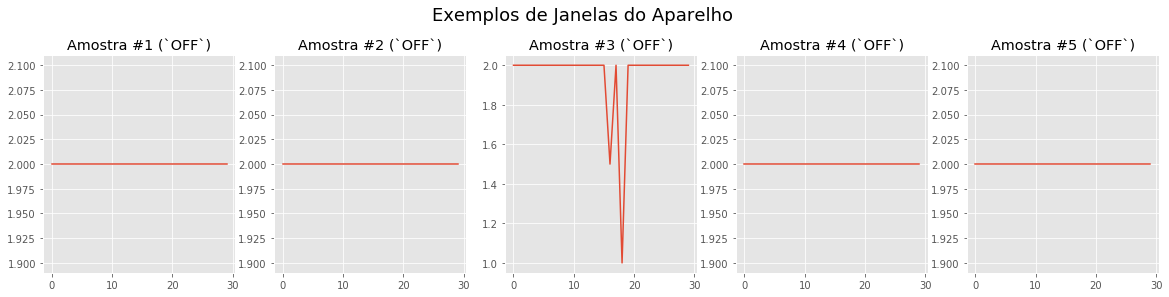

In [23]:
# Constantes referente aos dados da carga selecionada
TAXA = 5
TAMANHO_JANELA = 30

# Extrair series divididas em janelas para cada medidor
dados_cargas = janelas.preparar(
    taxa_amostral=TAXA, 
    intervalo_medicao=TAMANHO_JANELA
)
print()
dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(16, "microwave")])[0]

# Fazendo split dos dados (treino/teste)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    dados_aparelho["janelas"], dados_aparelho["rotulos"]["estado"],
    test_size=FRACAO_TESTE,
    stratify=dados_aparelho["rotulos"]["estado"],
    random_state=SEED
)

# Construindo datasets (treino e teste)
dataset_treino = tf.data.Dataset.from_tensor_slices((X_treino, y_treino))
dataset_teste = tf.data.Dataset.from_tensor_slices((X_teste, y_teste))

del X_treino
del y_treino
del X_teste
del y_teste
del dados_cargas
del dados_aparelho

# Exibindo algumas amostras de janealas
num_amostras = 5
fig, axes = plt.subplots(1, num_amostras, figsize=(20,4))
estados = {1: "ON", 0: "OFF"}
for i,amostra in enumerate(dataset_treino.shuffle(33).take(num_amostras)):
    serie = amostra[0].numpy()
    estado = amostra[1].numpy()
    axes[i].plot(np.arange(0, serie.shape[0]), serie)
    axes[i].set_title(f"Amostra #{i+1} (`{estados[estado]}`)")
plt.suptitle("Exemplos de Janelas do Aparelho", size=18, y=1.05)
plt.show()

**NOTA:** Interessante observar que algumas amostras estão rotuladas como `OFF` mesmo possuindo alguma curva no gráfico ou variação maior que 0. Isto ocorre pois tais sinais são tratados como ruído pela biblioteca NILMTK (conforme a baixa amplitude da medição), base do pré-processamento da PyNILM. Logo, é observado que os dados foram tratados corretamente.

In [24]:
# Construindo o pipeline de dados
# ----------

import cv2

# Constante fundamentais
TAMANHO_IMAGEM = (32,32,1) # Apenas 1 canal
TIPO_DADOS = np.float32
def serie_para_imagem(serie, params_rp = PARAMETROS_RP, tam_imagem=TAMANHO_IMAGEM):
    """
    Funcao responsavel por gerar e tratar a imagem RP.
    """
    # Gerando imagem RP/redimensionando
    imagem = RecurrencePlot(**params_rp).fit_transform([serie])[0]
    imagem = cv2.resize(
            imagem, 
            dsize=tam_imagem[:2], 
            interpolation=cv2.INTER_CUBIC
        ).astype(TIPO_DADOS)

    return np.stack([imagem for i in range(tam_imagem[-1])],axis=-1) # N canais

def preparar_amostra(amostra, rotulo):
    """
    Preparação da amostra/rótulo para o modelo.
    """
    # Convertendo serie para imagem
    amostra = tf.numpy_function(serie_para_imagem, [amostra], TIPO_DADOS)
    amostra = tf.reshape(amostra, TAMANHO_IMAGEM)
    return amostra, rotulo

# pipelines consolidados
dataset_treino = dataset_treino.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))

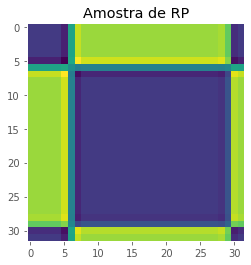

In [28]:
# Exemplo de amostra processada no pipeline
for a in dataset_treino.shuffle(SEED).batch(1).take(1):
    rp = a[0][0].numpy()
    plt.imshow(rp[:,:,0])
    plt.grid(False)
    plt.title("Amostra de RP")
    break

## Construindo o modelo

### Buscando o Overfitting

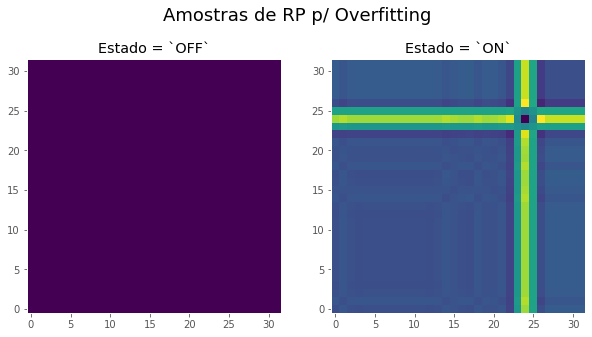

In [29]:
X,y = [], []

for amostra in dataset_treino.shuffle(SEED):
    imagem = amostra[0].numpy()
    rotulo = amostra[1].numpy()
    # Verificar se N possui amostra da classe
    if y.count(rotulo) == 0:
        X.append(imagem)
        y.append(rotulo)
    
    # Verificar se ja possui condicao de parada (1 de cada classe)
    if np.unique(y).shape[0] == 2:
        break
        
# Amostras selecionadas
fig, axes  = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(X[0][:,:,0], origin="lower")
axes[0].set_title(f"Estado = `{estados[y[0]]}`")
axes[0].grid(False)
axes[1].imshow(X[1][:,:,0], origin="lower")
axes[1].set_title(f"Estado = `{estados[y[1]]}`")
axes[1].grid(False)
plt.suptitle("Amostras de RP p/ Overfitting", size=18, y=1.0);

In [30]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, \
                    Dropout, MaxPool2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.constraints import max_norm

def modelo_baseline(optimizer, loss='binary_crossentropy', metrics=['accuracy'], name="Baseline"):
    
    model = Sequential(name=name)

    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="valid", kernel_initializer = 'he_uniform', input_shape=(32,32,1), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    model.add(AveragePooling2D())
    
#     model.add(Conv2D(32, kernel_size=(2,2), padding="valid", kernel_initializer = 'he_uniform', kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
#     model.add(BatchNormalization(trainable=False))
#     model.add(Activation("relu"))
#     model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization(trainable=False))
    model.add(Activation("relu"))
    #model.add(Dropout(0.2))
 
    # Output
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [31]:
modelo_overfitting = modelo_baseline(optimizer=tf.keras.optimizers.RMSprop(1e-2, momentum=0.5))

print("* Detalhes do modelo:")
print("---")
print(modelo_overfitting.summary())
print()

* Detalhes do modelo:
---
Model: "Baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               921728    
_________________________________________________________________
batch_normalization_1 (Batch (No

In [32]:
print("* Treinando:")
print("---")
historico = modelo_overfitting.fit(
    np.asarray(X).astype(TIPO_DADOS), np.array(y),
    epochs=10,
    verbose=2    
)

* Treinando:
---
Train on 2 samples
Epoch 1/10
2/2 - 4s - loss: 0.3466 - accuracy: 1.0000
Epoch 2/10
2/2 - 0s - loss: 0.3388 - accuracy: 1.0000
Epoch 3/10
2/2 - 0s - loss: 0.3041 - accuracy: 1.0000
Epoch 4/10
2/2 - 0s - loss: 118.4344 - accuracy: 0.5000
Epoch 5/10
2/2 - 0s - loss: 2.8335 - accuracy: 0.5000
Epoch 6/10
2/2 - 0s - loss: 0.0143 - accuracy: 1.0000
Epoch 7/10
2/2 - 0s - loss: 4.0630e-04 - accuracy: 1.0000
Epoch 8/10
2/2 - 0s - loss: 1.6829e-04 - accuracy: 1.0000
Epoch 9/10
2/2 - 0s - loss: 1.0662e-04 - accuracy: 1.0000
Epoch 10/10
2/2 - 0s - loss: 8.3870e-05 - accuracy: 1.0000


### Ajustando hiperparâmetros no conjunto completo

In [36]:
print("* Treinando modelo:")
print("---")
modelo = modelo_baseline(optimizer=tf.keras.optimizers.RMSprop(1e-2, momentum=0.5))
historico = modelo.fit(
    dataset_treino.batch(TAMANHO_LOTE),
    validation_data=dataset_teste.batch(TAMANHO_LOTE),
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=5)
    ],
    verbose=2    
)

* Treinando modelo:
---
Train for 97 steps, validate for 33 steps
Epoch 1/100
97/97 - 2s - loss: 50.5700 - accuracy: 0.9621 - val_loss: 0.0423 - val_accuracy: 0.9990
Epoch 2/100
97/97 - 1s - loss: 0.0994 - accuracy: 0.9974 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 3/100
97/97 - 1s - loss: 5.4898 - accuracy: 0.9951 - val_loss: 7.4201e-04 - val_accuracy: 1.0000
Epoch 4/100
97/97 - 1s - loss: 0.0050 - accuracy: 0.9984 - val_loss: 9.3020e-04 - val_accuracy: 0.9990
Epoch 5/100
97/97 - 1s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 4.0247e-04 - val_accuracy: 1.0000
Epoch 6/100
97/97 - 1s - loss: 1.4880e-04 - accuracy: 1.0000 - val_loss: 3.2230e-04 - val_accuracy: 1.0000
Epoch 7/100
97/97 - 1s - loss: 7.8289e-07 - accuracy: 1.0000 - val_loss: 1.0223e-04 - val_accuracy: 1.0000
Epoch 8/100
97/97 - 1s - loss: 2.1333e-07 - accuracy: 1.0000 - val_loss: 7.8246e-05 - val_accuracy: 1.0000


In [37]:
print()
print("-> Avaliando modelo/hipótese no conjunto de teste...")
y_true = [amostra[1].numpy() for amostra in dataset_teste]
y_pred = modelo.predict(dataset_teste.batch(TAMANHO_LOTE)).round()
print()
print(classification_report(y_pred, y_pred, target_names=("OFF", "ON")))


-> Avaliando modelo/hipótese no conjunto de teste...

              precision    recall  f1-score   support

         OFF       1.00      1.00      1.00      1018
          ON       1.00      1.00      1.00        11

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



# Avaliação da Arquitetura para demais Aparelhos

In [47]:
# Intervalo de tempo e residencia considerados na base REDD
janelas = Janelas(**PARAMETROS_DATASET)
modelos = []
# 1) Para cada aparelho dos considerados no paper IEE GM
for i, r in df_melhores_janelas.loc[
    (df_melhores_janelas["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ])), :
].iterrows():
    
    # Informacoes da carga (nome, id, taxa e janela)
    carga = r["carga"].split(" - ")[0]
    instancia = int(r["carga"].split(" - ")[1])
    taxa = r["taxa_amostragem"]
    janela = r["janela"]
    print(f"* `{r['carga'].upper()}` / taxa={taxa} e janela={janela} / benchmarking --> f1={r['f1_macro']}...")
    print()
    
    print("   - Carregando dados/janelas...")
    print("-----")
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=taxa, 
        intervalo_medicao=janela
    )
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]

    # Fazendo split dos dados (treino/teste)
    X_treino, X_teste, y_treino, y_teste = train_test_split(
        dados_aparelho["janelas"], dados_aparelho["rotulos"]["estado"],
        test_size=FRACAO_TESTE,
        stratify=dados_aparelho["rotulos"]["estado"],
        random_state=SEED
    )
    print()
          
    # Construindo datasets (treino e teste)
    print("   - Preparando dataset/tf.data...")
    print("-----")
    # pipelines consolidados
    dataset_treino = tf.data.Dataset.from_tensor_slices((X_treino, y_treino))
    dataset_treino = dataset_treino.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
    
    dataset_teste = tf.data.Dataset.from_tensor_slices((X_teste, y_teste))
    dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))
          
    del X_treino
    del y_treino
    del X_teste
    del y_teste
    del dados_cargas
    del dados_aparelho
          
    print()
    
    print("   - Treinando modelo classificador...")
    print("-----")
    modelo = modelo_baseline(optimizer=tf.keras.optimizers.RMSprop(1e-2, momentum=0.5))
    historico = modelo.fit(
        dataset_treino.batch(TAMANHO_LOTE),
        validation_data=dataset_teste.batch(TAMANHO_LOTE),
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=5)
        ],
        verbose=2    
    )
    print()
          
    print("   - Avaliando modelo/hipótese no conjunto de teste...")
    print("-----")
    y_true = [amostra[1].numpy() for amostra in dataset_teste]
    y_pred = modelo.predict(dataset_teste.batch(TAMANHO_LOTE)).round()
    print()
    print(classification_report(y_pred, y_pred))#, target_names=("OFF", "ON")))
    
    modelos.append({r["carga"]: modelo})
          
    print()
    print("-"*80)
    print()

* `FRIDGE - 7` / taxa=5 e janela=360 / benchmarking --> f1=100.0...

   - Carregando dados/janelas...
-----
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

   - Preparando dataset/tf.data...
-----

   - Treinando modelo classificador...
-----
Train for 9 steps, validate for 3 steps
Epoch 1/100
9/9 - 1s - loss: 5.9299 - accuracy: 0.9027 - val_loss: 0.8198 - val_accuracy: 0.9884
Epoch 2/100
9/9 - 0s - loss: 447.9598 - accuracy: 0.9027 - val_loss: 3.9534 - val_accuracy: 0.9884
Epoch 3/100
9/9 - 0s - loss: 5.1004 - accuracy: 0.9844 - val_loss: 2.8459 - val_accuracy: 0.9884
Epoch 4/100
9/9 - 0s - loss: 3.0607 - accuracy: 0.9883 - val_loss: 1.4034 - val_accuracy: 0.9884
Epoch 5/100
9/9 - 0s - loss: 0.9930 - accuracy: 0.9922 - val_loss: 0.0635 - val_accuracy: 0.9884
Epoch 6/100
9/9 - 0s - loss: 5.1591e-09 - accuracy: 1.0000 - val_loss: 6.3249e-08 - val_accuracy: 1.0000
Epoch 7/100
9/9 - 0s - loss: 1.1669e


   - Avaliando modelo/hipótese no conjunto de teste...
-----

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1017
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029


--------------------------------------------------------------------------------



# Avaliando Generalização

In [109]:
for m in modelos:
    print()

In [79]:
for i in redd.buildings:
    if i != 3:
        aparelhos_compartilhados = 0 
        aparelhos_residencia = {
            e.instance():e.label().lower().replace(" ","_") for e in redd.buildings[i].elec.meters}
        for m in modelos:
            aparelho_treino = list(m.keys())[0].split(" - ")[0]
            if aparelho_treino in aparelhos_residencia.values():
                aparelhos_compartilhados += 1
        print("Residencia", i, "-> Aparelhos compartilhados:", aparelhos_compartilhados)
        print()

Residencia 1 -> Aparelhos compartilhados: 5

Residencia 2 -> Aparelhos compartilhados: 5

Residencia 4 -> Aparelhos compartilhados: 3

Residencia 5 -> Aparelhos compartilhados: 5

Residencia 6 -> Aparelhos compartilhados: 4



In [111]:
def avaliar_generalizacao(janelas, instancia, carga, modelo):
    print("   - Carregando dados/janelas do aparelho `{}-{}`...".format(carga, instancia))
    print("-----")
    # Extrair series divididas em janelas para cada medidor
    dados_cargas = janelas.preparar(
        taxa_amostral=taxa, 
        intervalo_medicao=janela
    )
    dados_aparelho = janelas.filtrar_cargas(dados_cargas, filtros=[(instancia, carga)])[0]
    print()
          
    # Construindo datasets (treino e teste)
    print("   - Preparando dataset/tf.data...")
    print("-----")
    # pipelines consolidados
    dataset_teste = tf.data.Dataset.from_tensor_slices((dados_aparelho["janelas"], dados_aparelho["rotulos"]["estado"],))
    dataset_teste = dataset_teste.map(lambda amostra, rotulo: preparar_amostra(amostra, rotulo))

    del dados_cargas
    del dados_aparelho
          
    print()
    
          
    print("   - Avaliando modelo/hipótese no conjunto de teste...")
    print("-----")
    #modelo = list(m.values())[0]
    y_true = [amostra[1].numpy() for amostra in dataset_teste]
    y_pred = modelo.predict(dataset_teste.batch(TAMANHO_LOTE)).round()
    print()
    print(classification_report(y_pred, y_pred))#, target_names=("OFF", "ON")))
          
    print()
    print("-"*80)
    print()

In [118]:
residencia_generalizacao = 5

janelas = Janelas(**{
    'base': redd,
    'id_residencia': residencia_generalizacao,
    'inicio_intervalo': '2011-04-16 05:11:30',
    'fim_intervalo': '2011-04-23 08:43:26',
    'debug': False
})

aparelhos_residencia = {
    e.instance():e.label().lower().replace(" ","_") \
        for e in redd.buildings[residencia_generalizacao].elec.meters
}

for m in modelos:
    aparelho_treino = list(m.keys())[0].split(" - ")[0]
    
    # Localizar na residencia carga similar ao modelo treinado
    for k, v in aparelhos_residencia.items():
        if aparelho_treino == v:
            instancia = k
            carga = v
            break
    
    if type(instancia) == int:
        avaliar_generalizacao(janelas, instancia, carga, list(m.values())[0])
    else:
        for i in instancia:
            avaliar_generalizacao(janelas, i, carga, list(m.values())[0])

   - Carregando dados/janelas do aparelho `fridge-18`...
-----
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.

   - Preparando dataset/tf.data...
-----

   - Avaliando modelo/hipótese no conjunto de teste...
-----

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1211
         1.0       1.00      1.00      1.00       670

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881


--------------------------------------------------------------------------------

   - Carregando dados/janelas do aparelho `dish_washer-20`...
-----
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a n

# Conclusões

... TERMINAR OS TESTES, COM DEMAIS APARELHOS, CONSIDERANDO A ARQUITETURA ENCONTRADA ...

# Fim.

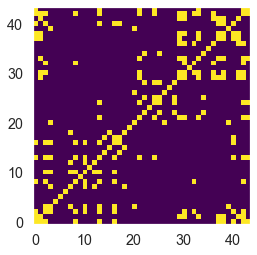

In [29]:
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

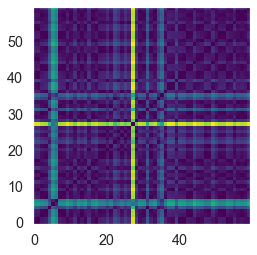

In [31]:
PARAMETROS_RP2 = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
X_rp = RecurrencePlot().set_params(**PARAMETROS_RP2).fit_transform(X)
plt.imshow(X_rp[0,:], cmap='viridis', origin='lower')
plt.grid(False)

In [32]:
X_rp

array([[[0.        , 0.00582504, 0.05967903, ..., 0.0553112 ,
         0.03347778, 0.0363903 ],
        [0.00582504, 0.        , 0.06550407, ..., 0.06113625,
         0.03930283, 0.03056526],
        [0.05967903, 0.06550407, 0.        , ..., 0.00436783,
         0.02620125, 0.09606934],
        ...,
        [0.0553112 , 0.06113625, 0.00436783, ..., 0.        ,
         0.02183342, 0.09170151],
        [0.03347778, 0.03930283, 0.02620125, ..., 0.02183342,
         0.        , 0.06986809],
        [0.0363903 , 0.03056526, 0.09606934, ..., 0.09170151,
         0.06986809, 0.        ]],

       [[0.        , 0.05205345, 0.01862383, ..., 0.4054451 ,
         0.41977167, 0.39064074],
        [0.05205345, 0.        , 0.03342962, ..., 0.45749855,
         0.47182512, 0.44269419],
        [0.01862383, 0.03342962, 0.        , ..., 0.42406893,
         0.4383955 , 0.40926456],
        ...,
        [0.4054451 , 0.45749855, 0.42406893, ..., 0.        ,
         0.01432657, 0.01480436],
        [0.4

In [39]:
X_rp[0,:].min()

0.0